In [5]:
import pickle
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Step 1: Load the saved fine-tune data from the pickle file
with open('fine_tune_data.pkl', 'rb') as f:
    fine_tune_data = pickle.load(f)  # This should be a list of (image, label) pairs

# Step 2: Separate images and labels, then convert them to tensors
images, labels = zip(*fine_tune_data)  # Unzip into two lists
images = torch.stack([torch.tensor(img) for img in images])  # Convert images to tensor
labels = torch.tensor(labels)  # Convert labels to tensor

# Step 3: Create a TensorDataset from the images and labels
fine_tune_dataset = TensorDataset(images, labels)

# Step 4: Define the split ratio for training and testing
train_ratio = 0.8  # 80% for training, 20% for testing
train_size = int(train_ratio * len(fine_tune_dataset))
test_size = len(fine_tune_dataset) - train_size

# Split the dataset
train_data, test_data = random_split(fine_tune_dataset, [train_size, test_size])

# Step 5: Create DataLoaders for training and testing
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

# Step 6: Verify the split by checking sample data from each loader
print("Training Set:")
for i, (train_images, train_labels) in enumerate(train_loader):
    print(f"Batch {i + 1} - Image Batch Shape: {train_images.shape}, Labels: {train_labels}")
    if i == 1:  # Limit to first few batches
        break

print("\nTesting Set:")
for i, (test_images, test_labels) in enumerate(test_loader):
    print(f"Batch {i + 1} - Image Batch Shape: {test_images.shape}, Labels: {test_labels}")
    if i == 1:  # Limit to first few batches
        break


Training Set:
Batch 1 - Image Batch Shape: torch.Size([4, 1, 28, 28]), Labels: tensor([1, 1, 1, 1])
Batch 2 - Image Batch Shape: torch.Size([4, 1, 28, 28]), Labels: tensor([1, 1, 1, 1])

Testing Set:
Batch 1 - Image Batch Shape: torch.Size([4, 1, 28, 28]), Labels: tensor([1, 1, 1, 1])
Batch 2 - Image Batch Shape: torch.Size([4, 1, 28, 28]), Labels: tensor([1, 1, 1, 1])


/var/folders/j0/w_sc6_7n777fy7v8ytm1r08w0000gn/T/ipykernel_3802/2198753815.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.stack([torch.tensor(img) for img in images])  # Convert images to tensor


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For progress bar

# Define a simple CNN model for binary classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjust for input dimensions
        self.fc2 = nn.Linear(128, 1)  # Binary output for label 1

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

# Step 1: Instantiate the model, define loss function and optimizer
model = SimpleCNN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Updated Training Function
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Ensure images have shape [batch_size, 1, 28, 28]
            images = images.float()  # No extra unsqueeze needed
            labels = labels.float().unsqueeze(1)  # Only for labels if needed
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print the loss at the end of each epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


# Step 3: Training the model
num_epochs = 5  # Adjust as needed
train_model(model, train_loader, criterion, optimizer, num_epochs)





Epoch 1/5: 100%|██████████| 135/135 [00:00<00:00, 206.47it/s]


Epoch [1/5], Loss: 0.0072


Epoch 2/5: 100%|██████████| 135/135 [00:00<00:00, 231.94it/s]


Epoch [2/5], Loss: 0.0000


Epoch 3/5: 100%|██████████| 135/135 [00:00<00:00, 227.46it/s]


Epoch [3/5], Loss: 0.0000


Epoch 4/5: 100%|██████████| 135/135 [00:00<00:00, 244.80it/s]


Epoch [4/5], Loss: 0.0000


Epoch 5/5: 100%|██████████| 135/135 [00:00<00:00, 224.39it/s]

Epoch [5/5], Loss: 0.0000
Test Accuracy: 100.00%


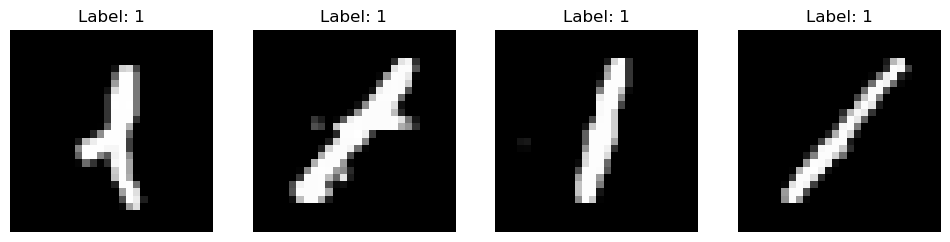

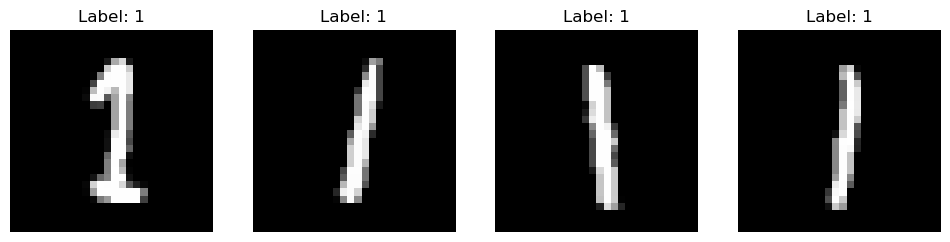

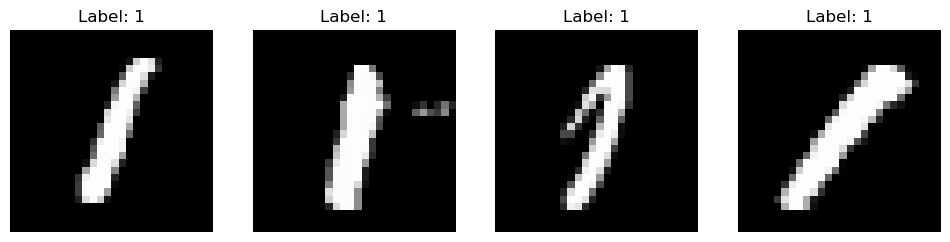

In [22]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

all_labels = []
all_predictions = []

# Initialize the counter for displayed images
image_counter = 0

with torch.no_grad():  # No need to compute gradients for evaluation
    for images, labels in test_loader:
        if image_counter >= 12:
            break  # Stop after displaying 12 images
        
        images = images.float()  # Convert to float tensor if needed
        labels = labels.float()  # No need to unsqueeze here if using sklearn metrics

        # Display images (up to 12 in total)
        num_images = min(5, images.size(0))  # Adjust based on batch size
        fig, axes = plt.subplots(1, num_images, figsize=(12, 6))
        for i in range(num_images):
            ax = axes[i]
            ax.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')  # Show image
            ax.set_title(f"Label: {int(labels[i].item())}")
            ax.axis('off')  # Hide axis
            image_counter += 1  # Increment the counter
            if image_counter >= 12:
                break  # Stop once 12 images are displayed
        plt.show()



In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # No need to compute gradients for evaluation
        for images, labels in test_loader:
            images = images.float()  # Convert to float tensor if needed
            labels = labels.float()  # No need to unsqueeze here if using sklearn metrics

            # Forward pass
            outputs = model(images)
            predictions = (outputs > 0.5).float()  # Apply threshold for binary classification

            all_labels.extend(labels.cpu().numpy())  # Store true labels
            all_predictions.extend(predictions.cpu().numpy())  # Store predictions

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions) * 100
    precision = precision_score(all_labels, all_predictions, zero_division=1)
    recall = recall_score(all_labels, all_predictions, zero_division=1)
    f1 = f1_score(all_labels, all_predictions, zero_division=1)
    cr = classification_report(all_labels, all_predictions, zero_division=1)

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Classification Report:\n {cr}")

# Run evaluation
evaluate_model(model, test_loader)

Test Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       135

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135



In [ ]:
import torch

# Save the model
model_path = 'fine_tuned_model_label_1.pth' 
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")


Model saved to fine_tuned_model_label_1.pth
